First we import the dataset from github and load the data as a pandas dataframe.

In [1]:
!pip install arviz==0.6.1
!pip install pymc3==3.8
!pip install Theano==1.0.4

     |████████████████████████████████| 1.4MB 5.0MB/s 
     |████████████████████████████████| 4.7MB 15.2MB/s 
     |████████████████████████████████| 317kB 37.5MB/s 
     |████████████████████████████████| 911kB 4.3MB/s 
  Found existing installation: pymc3 3.7
    Uninstalling pymc3-3.7:
      Successfully uninstalled pymc3-3.7
     |████████████████████████████████| 2.8MB 4.2MB/s 
  Created wheel for Theano: filename=Theano-1.0.4-cp36-none-any.whl size=2667178 sha256=222f1886587011fcf97bc706f3389e3d7d55312cea08dabaf1b87d17f73ef52a
  Stored in directory: /root/.cache/pip/wheels/88/fb/be/483910ff7e9f703f30a10605ad7605f3316493875c86637014
Successfully built Theano
  Found existing installation: Theano 1.0.5
    Uninstalling Theano-1.0.5:
      Successfully uninstalled Theano-1.0.5


In [2]:
!pwd
!wget https://raw.githubusercontent.com/leandroradusky/AdvancedStatistics/master/data/geneExpVsProliferation.tsv
!mkdir Assignment02
!mv geneExpVsProliferation.tsv Assignment02/
%cd Assignment02/

/content
--2021-02-08 10:39:03--  https://raw.githubusercontent.com/leandroradusky/AdvancedStatistics/master/data/geneExpVsProliferation.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62170 (61K) [text/plain]
Saving to: ‘geneExpVsProliferation.tsv’

geneExpVsProliferat 100%[===================>]  60.71K  --.-KB/s    in 0.01s   

2021-02-08 10:39:03 (4.64 MB/s) - ‘geneExpVsProliferation.tsv’ saved [62170/62170]

/content/Assignment02


In [3]:
!head geneExpVsProliferation.tsv

	GeneA	GeneB	GeneC	GeneD	GeneE	GeneF	GeneG	GeneH	DoublingTime
0	19.89	389.1	84.14	62.04	152.21	87.73	973.31	973.31	7.04
1	19.34	296.05	44.65	69.42	158.89	39.85	986.23	986.23	5.56
2	20.21	300.99	37.93	69.19	145.99	40.63	1033.5	1033.5	5.66
3	19.04	329.72	163.01	63.24	144.64	159.69	1082.32	1082.32	6.45
4	20.69	288.58	120.84	68.68	150.8	118.79	973.67	973.67	5.63
5	19.23	341.22	87.4	73.4	165.12	88.92	982.75	982.75	6.34
6	22.18	315.78	145.41	65.45	154.9	143.77	963.35	963.35	6.09
7	18.43	293.18	98.22	64.66	149.51	102.93	1045.43	1045.43	5.71
8	19.74	423.67	208.96	68.11	130.02	204.87	996.16	996.16	10.53


In [4]:
import pymc3 as pm
import math
import scipy
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
!pwd

/content/Assignment02


In [6]:
genesPath = "/content/Assignment02/geneExpVsProliferation.tsv"
genes = open(genesPath, "r")

In [7]:
df = pd.read_csv(genesPath, sep="\t", header = (0))
df = df.drop('Unnamed: 0', axis=1)
df.head()

,GeneA,GeneB,GeneC,GeneD,GeneE,GeneF,GeneG,GeneH,DoublingTime
0,19.89,389.10,84.14,62.04,152.21,87.73,973.31,973.31,7.04
1,19.34,296.05,44.65,69.42,158.89,39.85,986.23,986.23,5.56
2,20.21,300.99,37.93,69.19,145.99,40.63,1033.50,1033.50,5.66
3,19.04,329.72,163.01,63.24,144.64,159.69,1082.32,1082.32,6.45
4,20.69,288.58,120.84,68.68,150.80,118.79,973.67,973.67,5.63


### 1. Propose a threshhold to classify the cells as healthy and cancer cells.

We plot a histogram of the dataframe. We see that there are two different families of cells, one that has the average doubling time around 6 and the other one around 9. It seems to be a threshold around 8 of DoublingTime from which we can separate the two families.
Then we can perform a t-test between the two distributions.

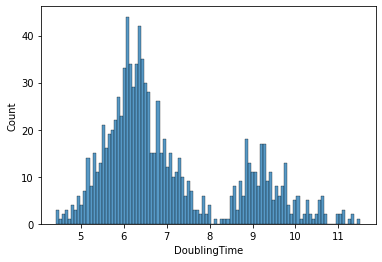

In [8]:
sns.histplot(df['DoublingTime'], bins= 100)

A t-test is a statistical test used to compare two distributions that follow a normal distribution in order to know if there are statistical differences between their means. To perform a t-test the groups wll have a independent categorical variable, cancer or no cancer cells in our case, and a continuous dependent variable, the DoublingTime in our case. 

As said before, we will separet the data in two families of cells, one considered "healthy" cells with a DoublingTime greater than 8, and the other considered cancer cells with a DoublingTime lower than 8; to see if the two families have significative differences between them we will perform a t-test.

In [65]:
cancer_cells = df.loc[df['DoublingTime'] <= 8]
healthy_cells = df.loc[df['DoublingTime'] > 8]

scipy.stats.ttest_ind(cancer_cells['DoublingTime'], healthy_cells['DoublingTime'], axis=0, equal_var=True)

Ttest_indResult(statistic=-63.62487672487075, pvalue=0.0)

In a t-test, is considered that two distributions have significative differences between them when the p-value is lower than 0.05, what means that the obtained result is not likely to be obtained by chance. In our case this p-value is practically 0, which means that we can say that the differences between the distributions are not likely to happen by chance and that they are two different distributions and, therefore, two different families of cells.

## 2. Construct a model in PyMC3 to test the influence of these marker genes in proliferation.

We start by doing an exploratory analysis to see how the DoublingTime of the cells behave respect to the gene expression of each gene. The orange points will be the family of healthy cells (higher DoublingTime) and the blue ones the family of cancer cells (lower DoublingTime).

16.84
22.71
17.02
22.47


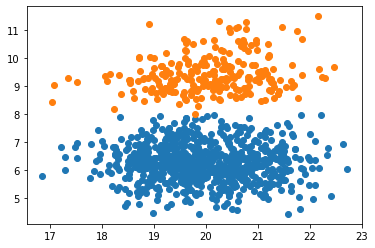

In [66]:
plt.plot(cancer_cells['GeneA'],cancer_cells['DoublingTime'], "o")
print(min(cancer_cells['GeneA']))
print(max(cancer_cells['GeneA']))
plt.plot(healthy_cells['GeneA'],healthy_cells['DoublingTime'], "o")
print(min(healthy_cells['GeneA']))
print(max(healthy_cells['GeneA']))

213.28
456.45
345.12
510.33


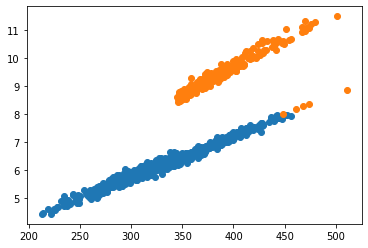

In [67]:
plt.plot(cancer_cells['GeneB'],cancer_cells['DoublingTime'], "o")
print(min(cancer_cells['GeneB']))
print(max(cancer_cells['GeneB']))
plt.plot(healthy_cells['GeneB'],healthy_cells['DoublingTime'], "o")
print(min(healthy_cells['GeneB']))
print(max(healthy_cells['GeneB']))

-26.79
209.98
77.1
218.53


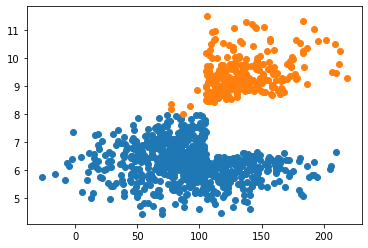

In [68]:
plt.plot(cancer_cells['GeneC'],cancer_cells['DoublingTime'], "o")
print(min(cancer_cells['GeneC']))
print(max(cancer_cells['GeneC']))
plt.plot(healthy_cells['GeneC'],healthy_cells['DoublingTime'], "o")
print(min(healthy_cells['GeneC']))
print(max(healthy_cells['GeneC']))

54.99
84.54
56.4
83.98


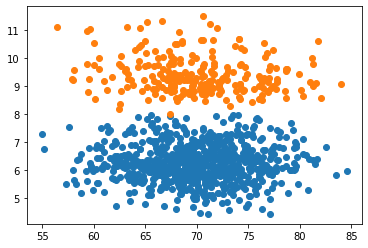

In [69]:
plt.plot(cancer_cells['GeneD'],cancer_cells['DoublingTime'], "o")
print(min(cancer_cells['GeneD']))
print(max(cancer_cells['GeneD']))
plt.plot(healthy_cells['GeneD'],healthy_cells['DoublingTime'], "o")
print(min(healthy_cells['GeneD']))
print(max(healthy_cells['GeneD']))

123.12
180.94
125.16
176.53


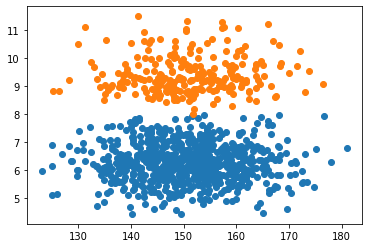

In [70]:
plt.plot(cancer_cells['GeneE'],cancer_cells['DoublingTime'], "o")
print(min(cancer_cells['GeneE']))
print(max(cancer_cells['GeneE']))
plt.plot(healthy_cells['GeneE'],healthy_cells['DoublingTime'], "o")
print(min(healthy_cells['GeneE']))
print(max(healthy_cells['GeneE']))

-29.26
212.59
79.25
220.36


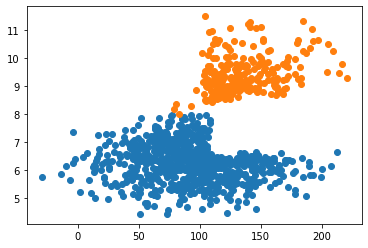

In [71]:
plt.plot(cancer_cells['GeneF'],cancer_cells['DoublingTime'], "o")
print(min(cancer_cells['GeneF']))
print(max(cancer_cells['GeneF']))
plt.plot(healthy_cells['GeneF'],healthy_cells['DoublingTime'], "o")
print(min(healthy_cells['GeneF']))
print(max(healthy_cells['GeneF']))

837.02
1177.92
866.04
1179.56


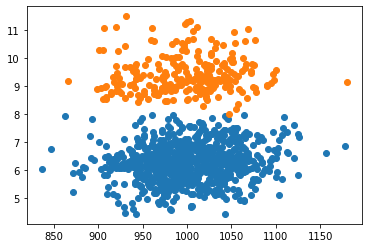

In [72]:
plt.plot(cancer_cells['GeneG'],cancer_cells['DoublingTime'], "o")
print(min(cancer_cells['GeneG']))
print(max(cancer_cells['GeneG']))
plt.plot(healthy_cells['GeneG'],healthy_cells['DoublingTime'], "o")
print(min(healthy_cells['GeneG']))
print(max(healthy_cells['GeneG']))

837.02
1177.92
866.04
1179.56


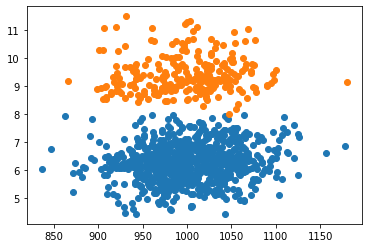

In [73]:
plt.plot(cancer_cells['GeneH'],cancer_cells['DoublingTime'], "o")
print(min(cancer_cells['GeneH']))
print(max(cancer_cells['GeneH']))
plt.plot(healthy_cells['GeneH'],healthy_cells['DoublingTime'], "o")
print(min(healthy_cells['GeneH']))
print(max(healthy_cells['GeneH']))

After ploting for all the genes we see that are some genes that have different expression levels in cancer cells or there is a different relationship between their expression level and the cells DoublingTime.

For example, for GeneB we se that there is a good lineal relationship between its expression and the Doubling Time, if the expression increases the Doubling Time increases too.  And there is a threshold around 350 where, if the gene expression is lower than this number almost all cells are cancer cells.

For genes C and F, we also see differences between cancer and healthy cells. The threshold is around 100, if the genes have an expression lower than this number the cells will be cancer cells.

For the other genes, they seem to have similar distributions for healthy and cancer genes. And also we can see that the GeneG and GeneH are actually the same gene. 

## The Model

We will do one model based on Markov Chain Monte Carlo in order to predict which is the influence of the expression of each gene in the Doubling Time of the cells. The same model will be applied to the cancer and healthy cells.

With this we will obtain the distribution for each parameter that models effect of each gene expression in the Doubling Time. We make an initial guess for each parameter, we say that they will be between -5 and 5, and the epsilon will have a mean = 0 and a std = 10.





In [76]:
with pm.Model() as model_cancer:
  
  GeneA = pm.Normal("GeneA", mu=cancer_cells['GeneA'].mean(), observed=cancer_cells['GeneA']) 
  GeneB = pm.Normal("GeneB", mu=cancer_cells['GeneB'].mean(), observed=cancer_cells['GeneB'])
  GeneC = pm.Normal("GeneC", mu=cancer_cells['GeneC'].mean(), observed=cancer_cells['GeneC'])
  GeneD = pm.Normal("GeneD", mu=cancer_cells['GeneD'].mean(), observed=cancer_cells['GeneD'])
  GeneE = pm.Normal("GeneE", mu=cancer_cells['GeneE'].mean(), observed=cancer_cells['GeneE'])
  GeneF = pm.Normal("GeneF", mu=cancer_cells['GeneF'].mean(), observed=cancer_cells['GeneF'])
  GeneG = pm.Normal("GeneG", mu=cancer_cells['GeneG'].mean(), observed=cancer_cells['GeneG'])
  GeneH = pm.Normal("GeneH", mu=cancer_cells['GeneH'].mean(), observed=cancer_cells['GeneH'])

  epsilon = pm.Normal("epsilon", mu=0, sigma=10)
  GeneA_coeff = pm.Uniform("GeneA_coeff", lower =-5, upper = 5 )
  GeneB_coeff = pm.Uniform("GeneB_coeff", lower =-5, upper = 5 )
  GeneC_coeff = pm.Uniform("GeneC_coeff", lower =-5, upper = 5 )
  GeneD_coeff = pm.Uniform("GeneD_coeff", lower =-5, upper = 5 )
  GeneE_coeff = pm.Uniform("GeneE_coeff", lower =-5, upper = 5 )
  GeneF_coeff = pm.Uniform("GeneF_coeff", lower =-5, upper = 5 )
  GeneG_coeff = pm.Uniform("GeneG_coeff", lower =-5, upper = 5 )
  GeneH_coeff = pm.Uniform("GeneH_coeff", lower =-5, upper = 5 )

  DoublingTime = pm.Normal('DoublingTime', mu = GeneA_coeff*GeneA + GeneB_coeff*GeneB + GeneC_coeff*GeneC+ GeneD_coeff*GeneD + GeneE_coeff*GeneE + \
                           GeneF_coeff*GeneF + GeneG_coeff*GeneG + GeneH_coeff*GeneH + epsilon, sigma=1, observed=cancer_cells['DoublingTime'])




In [77]:
with model_cancer:
  step = pm.Metropolis()
  trace = pm.sample(draws=10000, tune = 5000,step=step, cores = 10) # Cores = 10 to sample more chains and have a better convergence

Multiprocess sampling (10 chains in 10 jobs)
CompoundStep
>Metropolis: [GeneH_coeff]
>Metropolis: [GeneG_coeff]
>Metropolis: [GeneF_coeff]
>Metropolis: [GeneE_coeff]
>Metropolis: [GeneD_coeff]
>Metropolis: [GeneC_coeff]
>Metropolis: [GeneB_coeff]
>Metropolis: [GeneA_coeff]
>Metropolis: [epsilon]
Sampling 10 chains, 0 divergences: 100%|██████████| 150000/150000 [05:59<00:00, 417.71draws/s]
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


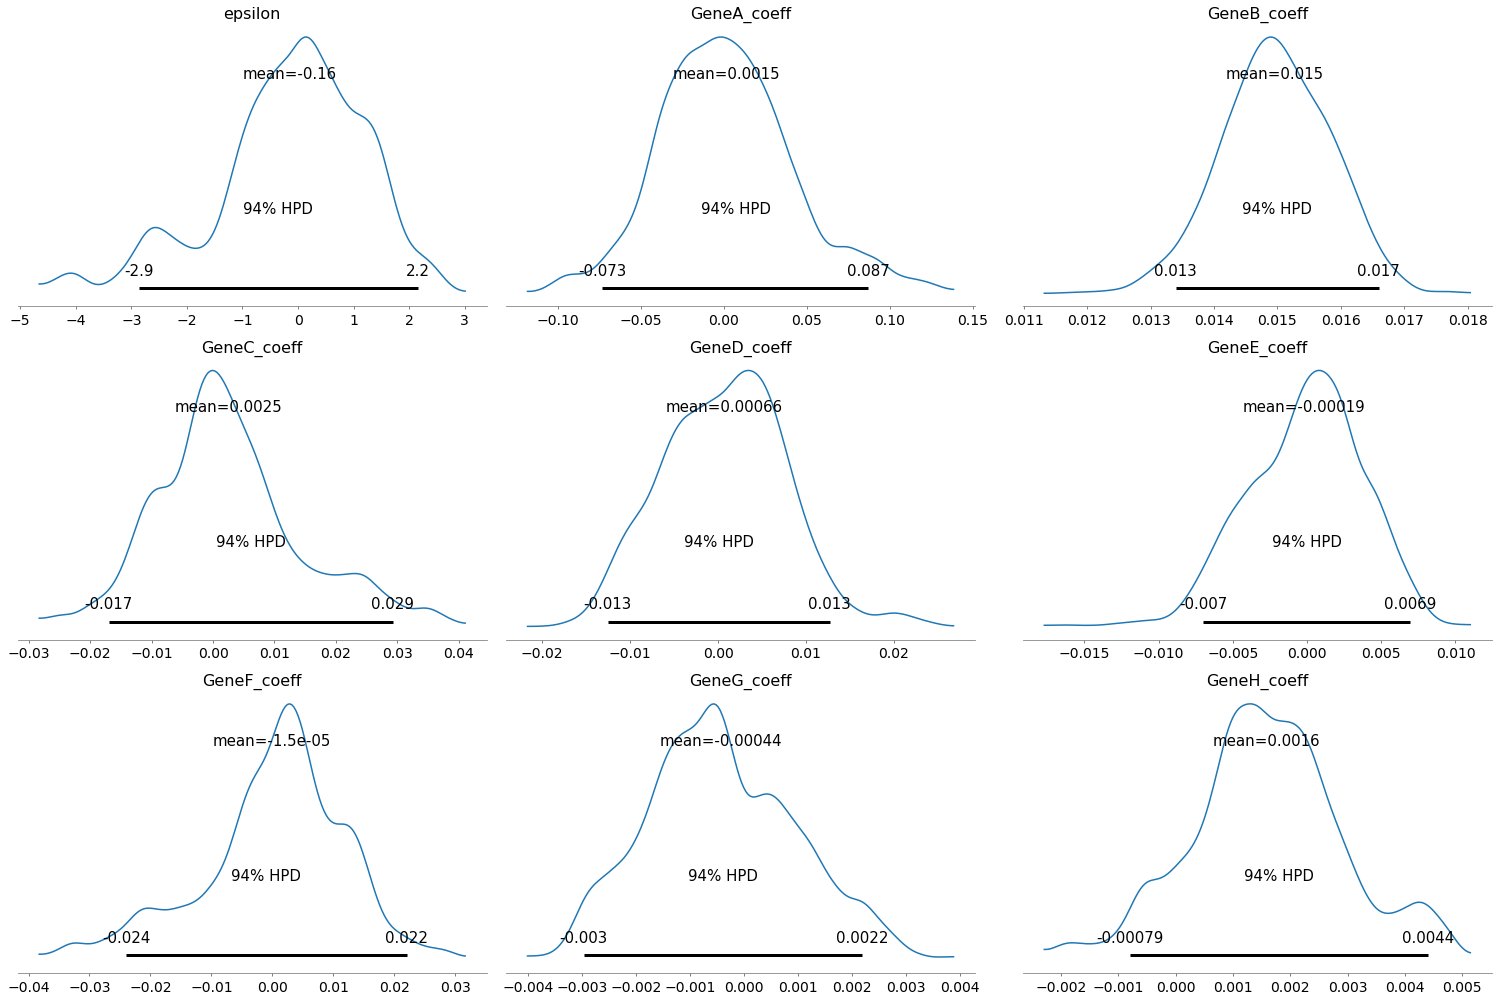

In [78]:
pm.plot_posterior(trace);

/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f518ada8f28>,
      dtype=object)

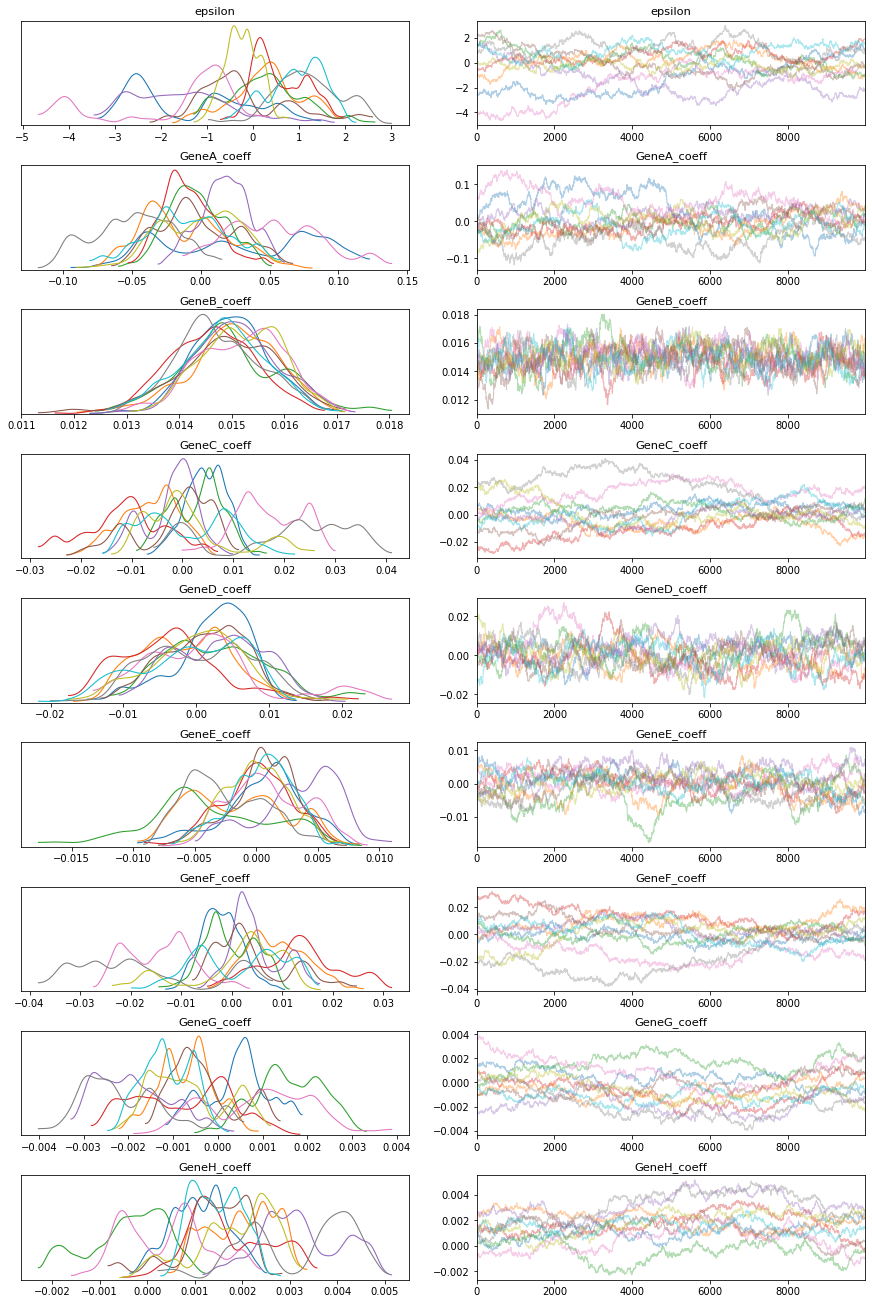

In [79]:
pm.traceplot(trace)

In [80]:
with pm.Model() as model_healthy:
  
  GeneA = pm.Normal("GeneA", mu=healthy_cells['GeneA'].mean(), observed=healthy_cells['GeneA'])
  GeneB = pm.Normal("GeneB", mu=healthy_cells['GeneB'].mean(), observed=healthy_cells['GeneB'])
  GeneC = pm.Normal("GeneC", mu=healthy_cells['GeneC'].mean(), observed=healthy_cells['GeneC'])
  GeneD = pm.Normal("GeneD", mu=healthy_cells['GeneD'].mean(), observed=healthy_cells['GeneD'])
  GeneE = pm.Normal("GeneE", mu=healthy_cells['GeneE'].mean(), observed=healthy_cells['GeneE'])
  GeneF = pm.Normal("GeneF", mu=healthy_cells['GeneF'].mean(), observed=healthy_cells['GeneF'])
  GeneG = pm.Normal("GeneG", mu=healthy_cells['GeneG'].mean(), observed=healthy_cells['GeneG'])
  GeneH = pm.Normal("GeneH", mu=healthy_cells['GeneH'].mean(), observed=healthy_cells['GeneH'])

  epsilon = pm.Normal("epsilon", mu=0, sigma=10)
  GeneA_coeff = pm.Uniform("GeneA_coeff", lower =-5, upper = 5 )
  GeneB_coeff = pm.Uniform("GeneB_coeff", lower =-5, upper = 5 )
  GeneC_coeff = pm.Uniform("GeneC_coeff", lower =-5, upper = 5 )
  GeneD_coeff = pm.Uniform("GeneD_coeff", lower =-5, upper = 5 )
  GeneE_coeff = pm.Uniform("GeneE_coeff", lower =-5, upper = 5 )
  GeneF_coeff = pm.Uniform("GeneF_coeff", lower =-5, upper = 5)
  GeneG_coeff = pm.Uniform("GeneG_coeff", lower =-5, upper = 5 )
  GeneH_coeff = pm.Uniform("GeneH_coeff", lower =-5, upper = 5 )

  DoublingTime = pm.Normal('DoublingTime', mu = GeneA_coeff*GeneA + GeneB_coeff*GeneB + GeneC_coeff*GeneC+ GeneD_coeff*GeneD + GeneE_coeff*GeneE + \
                           GeneF_coeff*GeneF + GeneG_coeff*GeneG + GeneH_coeff*GeneH + epsilon, sigma=1, observed=healthy_cells['DoublingTime'])

In [81]:
with model_healthy:
  step = pm.Metropolis()
  trace = pm.sample(draws=10000, tune = 5000, step=step, cores = 10)

Multiprocess sampling (10 chains in 10 jobs)
CompoundStep
>Metropolis: [GeneH_coeff]
>Metropolis: [GeneG_coeff]
>Metropolis: [GeneF_coeff]
>Metropolis: [GeneE_coeff]
>Metropolis: [GeneD_coeff]
>Metropolis: [GeneC_coeff]
>Metropolis: [GeneB_coeff]
>Metropolis: [GeneA_coeff]
>Metropolis: [epsilon]
Sampling 10 chains, 0 divergences: 100%|██████████| 150000/150000 [05:36<00:00, 445.36draws/s]
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


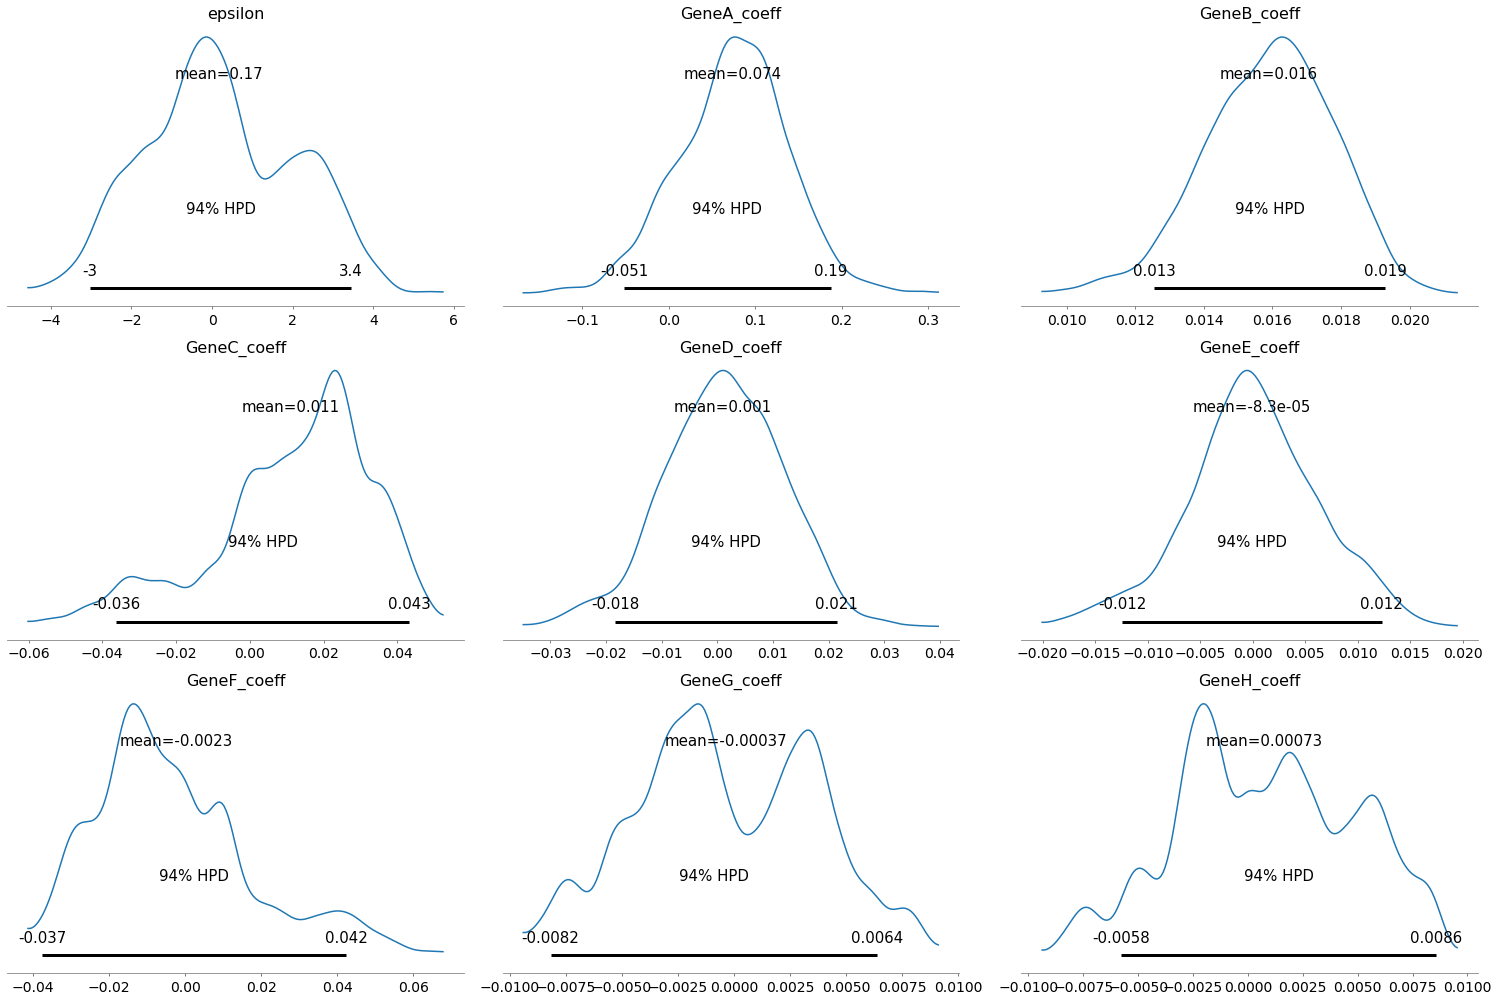

In [82]:
pm.plot_posterior(trace);

/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f51863692b0>,
      dtype=object)

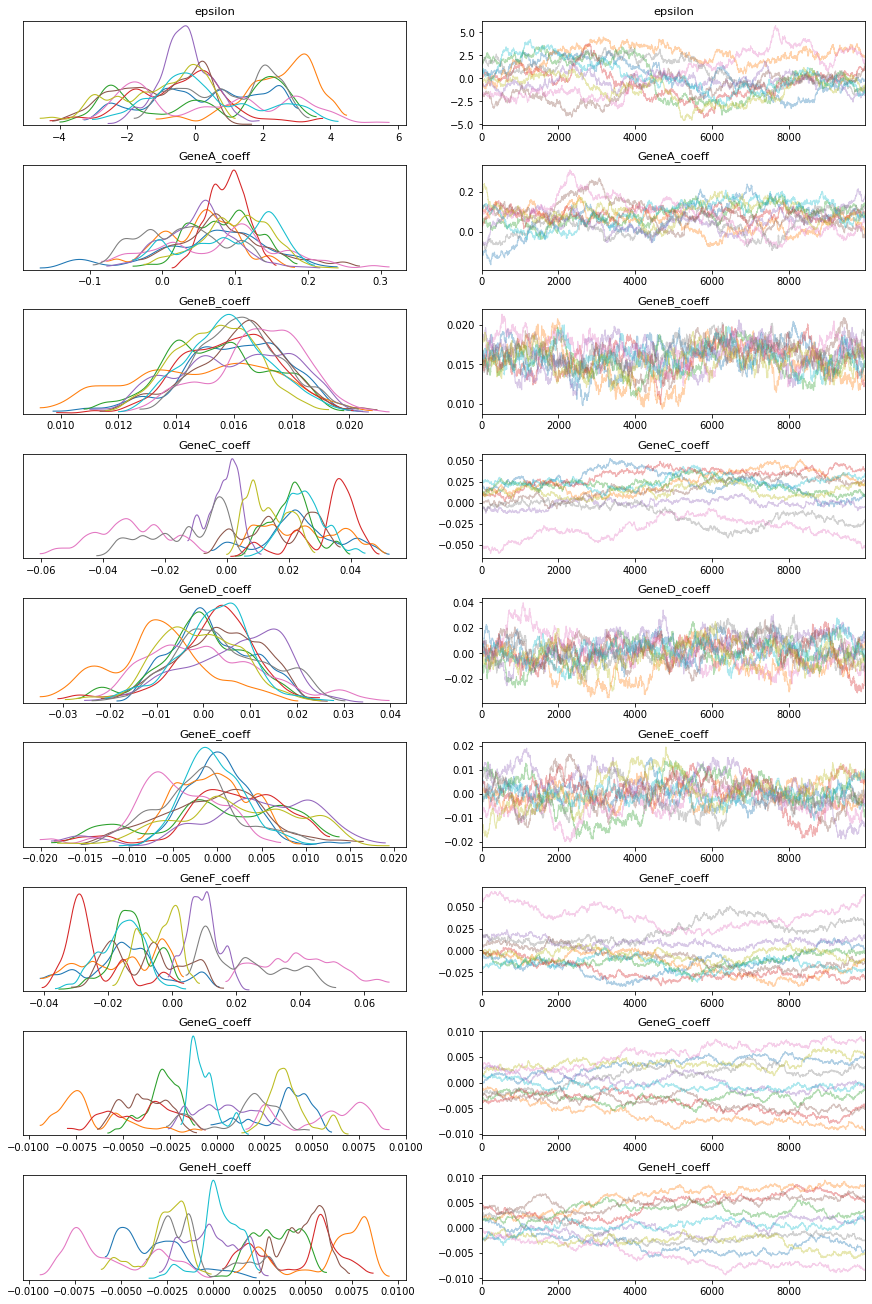

In [83]:
pm.traceplot(trace)

## Conclusions

As a conclusions of this analysis we can extract two main things:

First, the expression of some genes is different in cancer than in healthy cells. This can be seen in genes B, C and F for which below a given threshold (350, 100 and 100 respectively) all the cells are cancer cells, so when these genes are highly expressed the cells are healthy cells.

Second, we can detect how the expression of some genes affects the Doubling Time. For genes D, E, G, F and H the effect of the expression is almost 0 both in the cancer and the healthy cells. 
Then, we have the genes A and C, for which we have a low effect in cancer cells (means = 0.0015, 0.0025) and a higher effect in the Doubling Time in healthy cells (means = 0.074, 0.011). 
Finally, the gene B is the one with the higher effect in the doubling time and, as seen on the plots, the higher the expression the higher the Doubling Time.



## Comment

I have done all the work taking into account that the Doubling Time is what I found in the literature: the time that takes to a population of cells to double its size. And, knowing that the cancer cells growth faster than the healthy ones, the cancer cells will have a lower Doubling time than the healthy cells.